**Google Drive'ı Colab'a Bağlama**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Proje Klasörünün Yolunu Doğrulama**

In [2]:
!ls "/content/drive/My Drive/Bitirme Projesi/SpineCheck-AI"

backend			 dataset_resized     temp
convert_yolo_dataset.py  frontend	     tools
dataset			 inference.py	     training
dataset_all_clean	 models		     train.ipynb
dataset_all_resized	 post_processing.py  unet_architecture
dataset_clean		 README.md	     unet_architecture.png
dataset_old		 spine_dataset	     venv


**Proje Dizinine Geçme ve Python Path'ini Ayarlama**

In [3]:
import os
import sys

# Define the project directory as a variable (use quotes if there are spaces)
project_directory = "/content/drive/My Drive/Bitirme Projesi/SpineCheck-AI"

# Set the working directory to the project folder
os.chdir(project_directory)
print(f"Working directory: {os.getcwd()}")

# Add the project folder to the Python path
if project_directory not in sys.path:
    sys.path.append(project_directory)
    print(f"Added to Python path: {project_directory}")

Working directory: /content/drive/My Drive/Bitirme Projesi/SpineCheck-AI
Added to Python path: /content/drive/My Drive/Bitirme Projesi/SpineCheck-AI


**Gerekli Bağımlılıkları Yükleme**

In [ ]:
!pip install -r backend/requirements.txt

**Gerekli Kütüphaneleri İçe Aktarma**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



Model registration path: /content/drive/My Drive/Bitirme Projesi/SpineCheck-AI/models/unet_model_best_colab_harun.pth


**Proje Modüllerini İçeri Aktarma**

In [5]:
# Import Backend and Training modules
try:
    from backend.models.unet import UNet
    from training.dataset import XrayDataset, YOLOSpineDataset, CombinedDataset
    from training.train import DiceLoss, combined_loss, train_model

    print("Modules imported successfully!")
except ImportError as e:
    print(f"Module import error: {e}")

    # Let's learn more in case of error
    import traceback
    traceback.print_exc()

Modules imported successfully!


**GPU Kullanılabilirliğini Kontrol Etme**

In [ ]:
# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

# Set up the device (force GPU utilization)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device to be used: {device}")

if device.type == 'cuda':
    print(f"GPU used: {torch.cuda.get_device_name(0)}")
    !nvidia-smi
else:
    print("GPU not found! Training will be performed on CPU and may be too slow.")
    print("Do not forget to change the runtime type to GPU!")

CUDA available: True
Device to be used: cuda
GPU used: NVIDIA L4
Sun May  4 23:33:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |       

**Veri Setini İnceleme**

In [ ]:
import torch.utils.data as data

# Set up data paths
raw_dir = os.path.join(project_directory, "dataset", "raw")
masks_dir = os.path.join(project_directory, "dataset", "masks")

# Create datasets
def create_datasets(batch_size=12, val_split=0.2):
    print(f"Checking data folders...")
    print(f"Raw folder: {os.path.exists(raw_dir)}")
    print(f"Masks folder: {os.path.exists(masks_dir)}")

    # Main datasets
    datasets = []

    # Add main dataset
    if os.path.exists(raw_dir) and os.path.exists(masks_dir):
        mask_files = os.listdir(masks_dir)
        print(f"Number of masks found: {len(mask_files)}")

        if len(mask_files) > 0:
            print("Creating manually labeled dataset...")
            dataset = XrayDataset(raw_dir, masks_dir, augment=True)
            datasets.append(dataset)
            print(f"Main dataset size: {len(dataset)}")

    # Dataset check
    if len(datasets) == 0:
        raise ValueError("No usable datasets found!")

    # Combine datasets
    if len(datasets) == 1:
        combined_dataset = datasets[0]
    else:
        combined_dataset = CombinedDataset(datasets)

    # Split for training and validation
    dataset_size = len(combined_dataset)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size

    train_dataset, val_dataset = data.random_split(
        combined_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Total: {dataset_size} images")
    print(f"Training: {train_size} images")
    print(f"Validation: {val_size} images")

    # Create data loaders
    train_loader = data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False
    )

    val_loader = data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False
    )

    return train_loader, val_loader

# Create data loaders
train_loader, val_loader = create_datasets(batch_size=12)

Checking data folders...
Raw folder: True
Masks folder: True
Number of masks found: 737
Creating manually labeled dataset...
Main dataset size: 737
Total: 737 images
Training: 590 images
Validation: 147 images


**Model Eğitimini Başlatma**

In [ ]:
def advanced_training_monitoring(model, device, train_loader, val_loader, epochs=100,
                           lr=1e-4, save_dir=None, checkpoint_freq=5):
    """
    Model training with enhanced monitoring and visualization
    """
    # Set up saving directory
    if save_dir is None:
        save_dir = os.path.join(project_directory, "models")
    os.makedirs(save_dir, exist_ok=True)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Lists for monitoring
    train_losses = []
    val_losses = []
    dice_scores = []
    epochs_list = []
    lr_rates = []

    # Best model tracking
    best_val_loss = float('inf')

    # Training start time
    total_start_time = time.time()

    print(f"\n{'='*15} TRAINING STARTED {'='*15}")
    print(f"Total epochs: {epochs}")
    print(f"Initial learning rate: {lr}")
    print(f"Device: {device}")
    print(f"Number of batches: {len(train_loader)}")
    print(f"{'='*40}\n")

    # Epoch loop
    for epoch in range(epochs):
        epoch_start_time = time.time()

        # -------------- Training Phase --------------
        model.train()
        train_epoch_loss = 0

        # Training progress bar
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)
        for batch in train_loop:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update progress bar
            batch_loss = loss.item()
            train_epoch_loss += batch_loss
            train_loop.set_postfix(loss=f"{batch_loss:.4f}")

        # Average training loss
        train_loss = train_epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # -------------- Validation Phase --------------
        model.eval()
        val_epoch_loss = 0
        epoch_dice_score = 0

        # Validation progress bar
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        with torch.no_grad():
            for batch in val_loop:
                images, masks = batch
                images, masks = images.to(device), masks.to(device)

                # Forward pass
                outputs = model(images)
                loss = combined_loss(outputs, masks)

                # Calculate Dice score
                pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                intersection = (pred_masks * masks).sum()
                dice = (2. * intersection) / (pred_masks.sum() + masks.sum() + 1e-8)

                # Add values
                val_epoch_loss += loss.item()
                epoch_dice_score += dice.item()

                # Update progress bar
                val_loop.set_postfix(loss=f"{loss.item():.4f}", dice=f"{dice.item():.4f}")

        # Average validation metrics
        val_loss = val_epoch_loss / len(val_loader)
        dice_score = epoch_dice_score / len(val_loader)

        val_losses.append(val_loss)
        dice_scores.append(dice_score)
        epochs_list.append(epoch + 1)

        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        lr_rates.append(current_lr)

        # Calculate epoch duration
        epoch_time = time.time() - epoch_start_time

        # --------- Print Results ---------
        print(f"\nEpoch {epoch+1}/{epochs} - {epoch_time:.1f}s")
        print(f"  Training Loss: {train_loss:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")
        print(f"  Dice Score: {dice_score:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # --------- Save Model ---------
        # Best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, "unet_model_best_colab.pth"))
            print(f"  ✅ New best model saved! (Val Loss: {val_loss:.4f})")

        # Checkpoint
        if (epoch + 1) % checkpoint_freq == 0:
            checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch{epoch+1}.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'dice_score': dice_score,
            }, checkpoint_path)
            print(f"  📁 Checkpoint saved: epoch_{epoch+1}")

        # --------- Visualize Progress ---------
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            # Draw loss and dice graphs
            plt.figure(figsize=(15, 5))

            # Loss graph
            plt.subplot(1, 3, 1)
            plt.plot(epochs_list, train_losses, 'b-', label='Training Loss')
            plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training and Validation Losses')
            plt.grid(True, alpha=0.3)

            # Dice score graph
            plt.subplot(1, 3, 2)
            plt.plot(epochs_list, dice_scores, 'g-')
            plt.xlabel('Epoch')
            plt.ylabel('Dice Score')
            plt.title('Validation Dice Score')
            plt.grid(True, alpha=0.3)

            # Learning rate graph
            plt.subplot(1, 3, 3)
            plt.plot(epochs_list, lr_rates, 'm-')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate Changes')
            plt.grid(True, alpha=0.3)
            plt.yscale('log')

            plt.tight_layout()
            plt.show()

    # Training completed
    total_time = time.time() - total_start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    print(f"\n{'='*15} TRAINING COMPLETED {'='*15}")
    print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Final Dice score: {dice_scores[-1]:.4f}")
    print(f"Model saved: {os.path.join(save_dir, 'unet_model_best_colab.pth')}")
    print(f"{'='*46}")

    # Draw final graphs
    plt.figure(figsize=(15, 10))

    # Loss graph
    plt.subplot(2, 2, 1)
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.grid(True, alpha=0.3)

    # Dice score graph
    plt.subplot(2, 2, 2)
    plt.plot(epochs_list, dice_scores, 'g-')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Validation Dice Score')
    plt.grid(True, alpha=0.3)

    # Learning rate graph
    plt.subplot(2, 2, 3)
    plt.plot(epochs_list, lr_rates, 'm-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Changes')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dice_scores': dice_scores,
        'best_val_loss': best_val_loss,
        'final_dice_score': dice_scores[-1]
    }

**Modeli Yükleme ve Tahmin Yapma**

Model created and moved to GPU.

Model Architecture:
Total number of parameters: 17,262,977
Number of trainable parameters: 17,262,977

=============== TRAINING STARTED ===============
Total epochs: 50
Initial learning rate: 0.0001
Device: cuda
Number of batches: 50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1/50 - 91.8s
  Training Loss: 0.6346
  Validation Loss: 0.5811
  Dice Score: 0.4774
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.5811)


Epoch 2/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2/50 - 63.3s
  Training Loss: 0.5483
  Validation Loss: 0.5468
  Dice Score: 0.5418
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.5468)


Epoch 3/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3/50 - 63.4s
  Training Loss: 0.5196
  Validation Loss: 0.5211
  Dice Score: 0.6160
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.5211)


Epoch 4/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4/50 - 63.7s
  Training Loss: 0.4993
  Validation Loss: 0.4900
  Dice Score: 0.6336
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.4900)


Epoch 5/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5/50 - 63.9s
  Training Loss: 0.4748
  Validation Loss: 0.4680
  Dice Score: 0.6606
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.4680)
  📁 Checkpoint saved: epoch_5


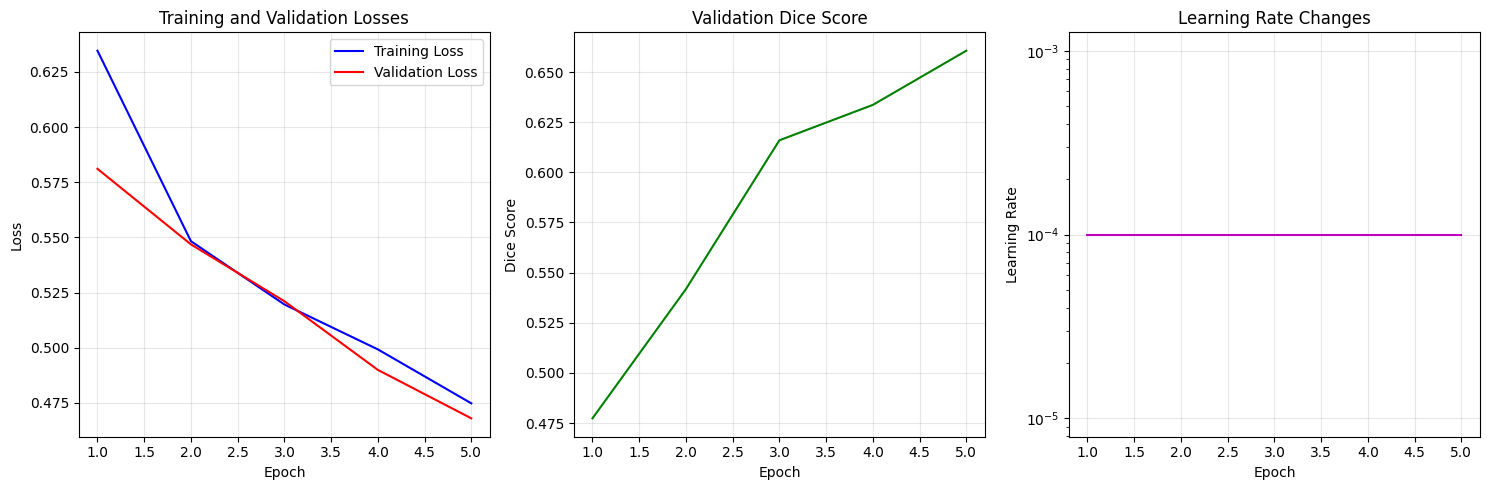

Epoch 6/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6/50 - 63.3s
  Training Loss: 0.4508
  Validation Loss: 0.4459
  Dice Score: 0.6448
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.4459)


Epoch 7/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7/50 - 63.9s
  Training Loss: 0.4297
  Validation Loss: 0.4273
  Dice Score: 0.7061
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.4273)


Epoch 8/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8/50 - 63.9s
  Training Loss: 0.4081
  Validation Loss: 0.4270
  Dice Score: 0.6677
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.4270)


Epoch 9/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9/50 - 63.8s
  Training Loss: 0.3958
  Validation Loss: 0.4385
  Dice Score: 0.5709
  Learning Rate: 0.000100


Epoch 10/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 10/50 - 63.9s
  Training Loss: 0.3744
  Validation Loss: 0.3758
  Dice Score: 0.7223
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.3758)
  📁 Checkpoint saved: epoch_10


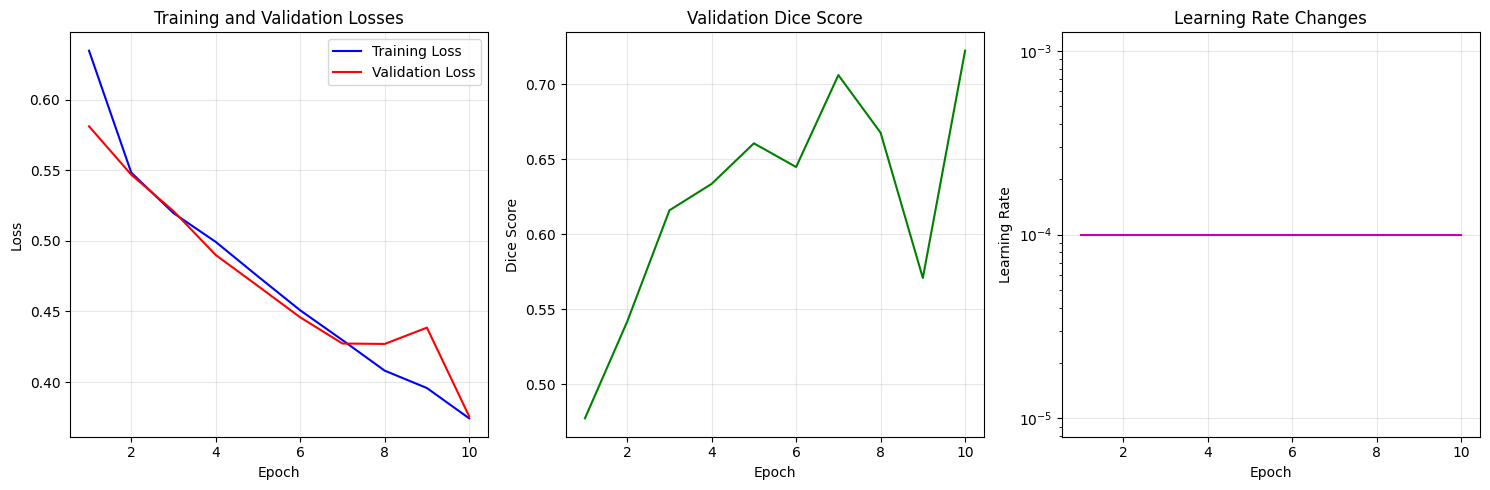

Epoch 11/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11/50 - 65.1s
  Training Loss: 0.3549
  Validation Loss: 0.3495
  Dice Score: 0.7420
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.3495)


Epoch 12/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12/50 - 63.8s
  Training Loss: 0.3409
  Validation Loss: 0.3381
  Dice Score: 0.7469
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.3381)


Epoch 13/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13/50 - 63.9s
  Training Loss: 0.3250
  Validation Loss: 0.3260
  Dice Score: 0.7332
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.3260)


Epoch 14/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14/50 - 63.9s
  Training Loss: 0.3106
  Validation Loss: 0.3164
  Dice Score: 0.7432
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.3164)


Epoch 15/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15/50 - 64.0s
  Training Loss: 0.2972
  Validation Loss: 0.3317
  Dice Score: 0.6735
  Learning Rate: 0.000100
  📁 Checkpoint saved: epoch_15


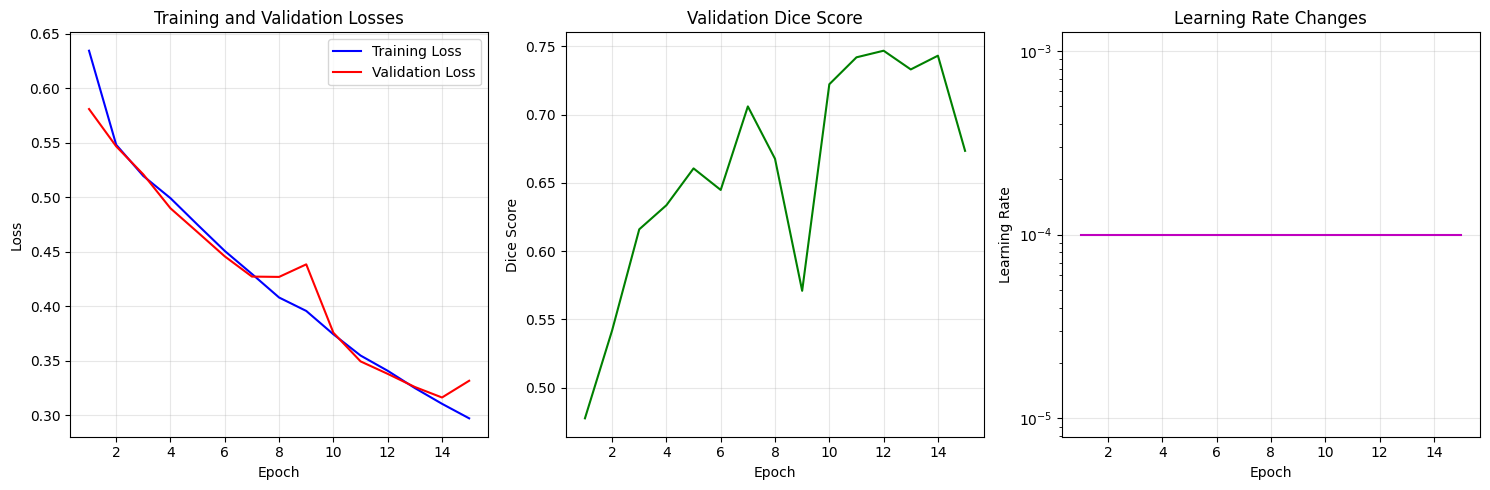

Epoch 16/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 16/50 - 63.8s
  Training Loss: 0.2835
  Validation Loss: 0.2850
  Dice Score: 0.7552
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2850)


Epoch 17/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 17/50 - 63.8s
  Training Loss: 0.2678
  Validation Loss: 0.2732
  Dice Score: 0.7614
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2732)


Epoch 18/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 18/50 - 64.1s
  Training Loss: 0.2555
  Validation Loss: 0.2582
  Dice Score: 0.7762
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2582)


Epoch 19/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 19/50 - 64.2s
  Training Loss: 0.2467
  Validation Loss: 0.2503
  Dice Score: 0.7717
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2503)


Epoch 20/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 20/50 - 64.0s
  Training Loss: 0.2354
  Validation Loss: 0.2408
  Dice Score: 0.7777
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2408)
  📁 Checkpoint saved: epoch_20


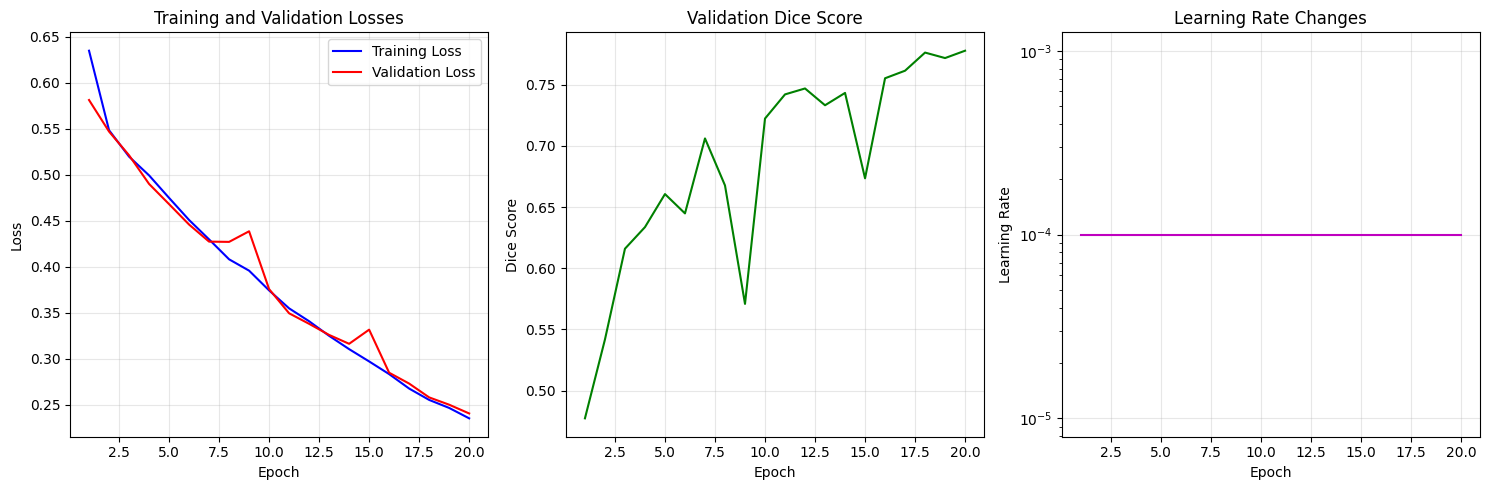

Epoch 21/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 21/50 - 64.1s
  Training Loss: 0.2274
  Validation Loss: 0.2282
  Dice Score: 0.7821
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2282)


Epoch 22/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 22/50 - 63.8s
  Training Loss: 0.2144
  Validation Loss: 0.2383
  Dice Score: 0.7498
  Learning Rate: 0.000100


Epoch 23/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 23/50 - 64.0s
  Training Loss: 0.2088
  Validation Loss: 0.2134
  Dice Score: 0.7867
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2134)


Epoch 24/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 24/50 - 64.0s
  Training Loss: 0.2008
  Validation Loss: 0.2101
  Dice Score: 0.7898
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2101)


Epoch 25/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 25/50 - 64.0s
  Training Loss: 0.1945
  Validation Loss: 0.2062
  Dice Score: 0.7855
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.2062)
  📁 Checkpoint saved: epoch_25


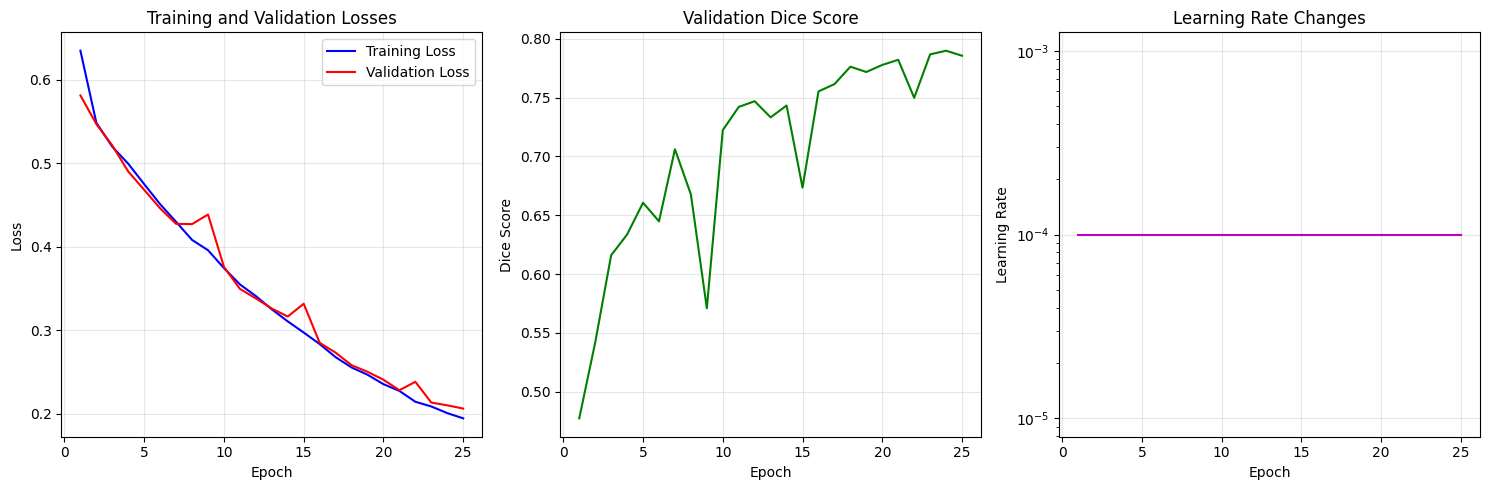

Epoch 26/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 26/50 - 63.6s
  Training Loss: 0.1922
  Validation Loss: 0.1873
  Dice Score: 0.8049
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1873)


Epoch 27/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 27/50 - 63.9s
  Training Loss: 0.1822
  Validation Loss: 0.1851
  Dice Score: 0.8018
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1851)


Epoch 28/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 28/50 - 64.1s
  Training Loss: 0.1759
  Validation Loss: 0.1856
  Dice Score: 0.8052
  Learning Rate: 0.000100


Epoch 29/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 29/50 - 63.9s
  Training Loss: 0.1701
  Validation Loss: 0.1773
  Dice Score: 0.8062
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1773)


Epoch 30/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 30/50 - 64.1s
  Training Loss: 0.1684
  Validation Loss: 0.1805
  Dice Score: 0.7976
  Learning Rate: 0.000100
  📁 Checkpoint saved: epoch_30


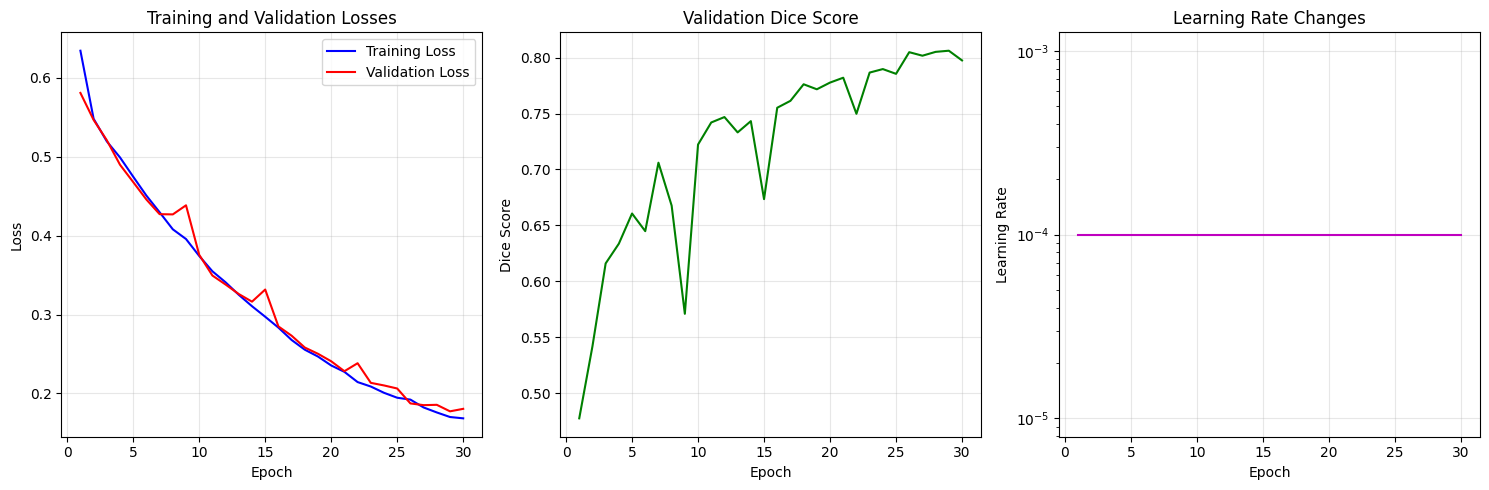

Epoch 31/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 31/50 - 64.2s
  Training Loss: 0.1625
  Validation Loss: 0.1766
  Dice Score: 0.8019
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1766)


Epoch 32/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 32/50 - 63.9s
  Training Loss: 0.1585
  Validation Loss: 0.1722
  Dice Score: 0.7995
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1722)


Epoch 33/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 33/50 - 63.8s
  Training Loss: 0.1544
  Validation Loss: 0.1617
  Dice Score: 0.8102
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1617)


Epoch 34/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 34/50 - 64.0s
  Training Loss: 0.1513
  Validation Loss: 0.1630
  Dice Score: 0.8073
  Learning Rate: 0.000100


Epoch 35/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 35/50 - 64.0s
  Training Loss: 0.1509
  Validation Loss: 0.1677
  Dice Score: 0.7966
  Learning Rate: 0.000100
  📁 Checkpoint saved: epoch_35


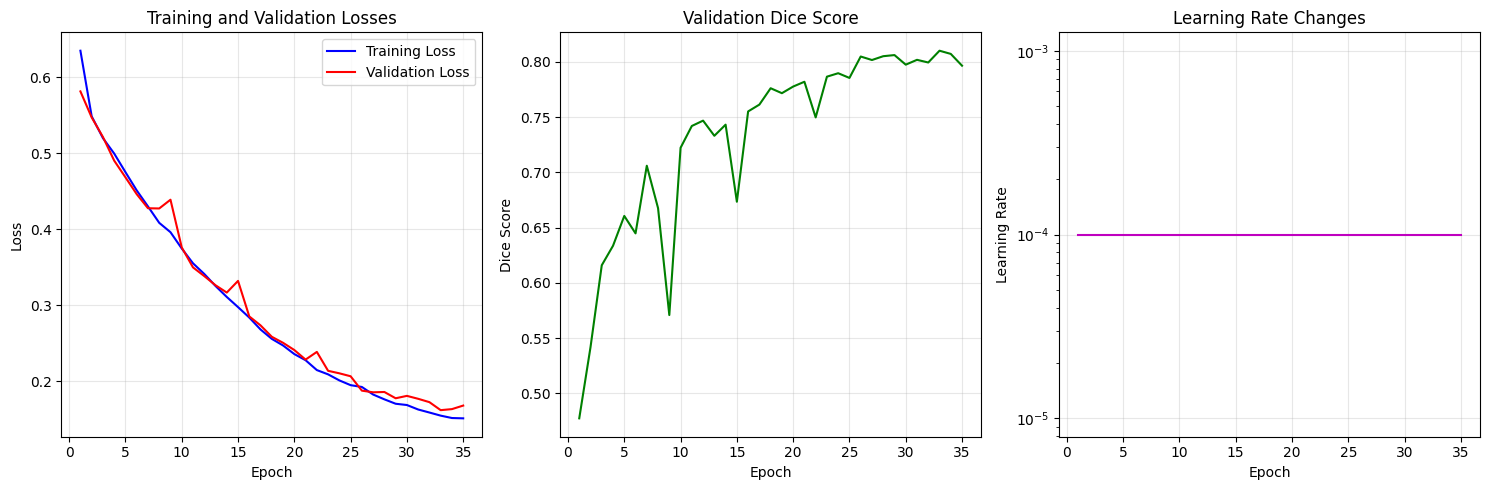

Epoch 36/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 36/50 - 64.4s
  Training Loss: 0.1455
  Validation Loss: 0.1547
  Dice Score: 0.8146
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1547)


Epoch 37/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 37/50 - 64.1s
  Training Loss: 0.1428
  Validation Loss: 0.1540
  Dice Score: 0.8117
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1540)


Epoch 38/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 38/50 - 64.1s
  Training Loss: 0.1421
  Validation Loss: 0.1538
  Dice Score: 0.8075
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1538)


Epoch 39/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 39/50 - 64.1s
  Training Loss: 0.1397
  Validation Loss: 0.1533
  Dice Score: 0.8060
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1533)


Epoch 40/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 40/50 - 63.9s
  Training Loss: 0.1355
  Validation Loss: 0.1461
  Dice Score: 0.8156
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1461)
  📁 Checkpoint saved: epoch_40


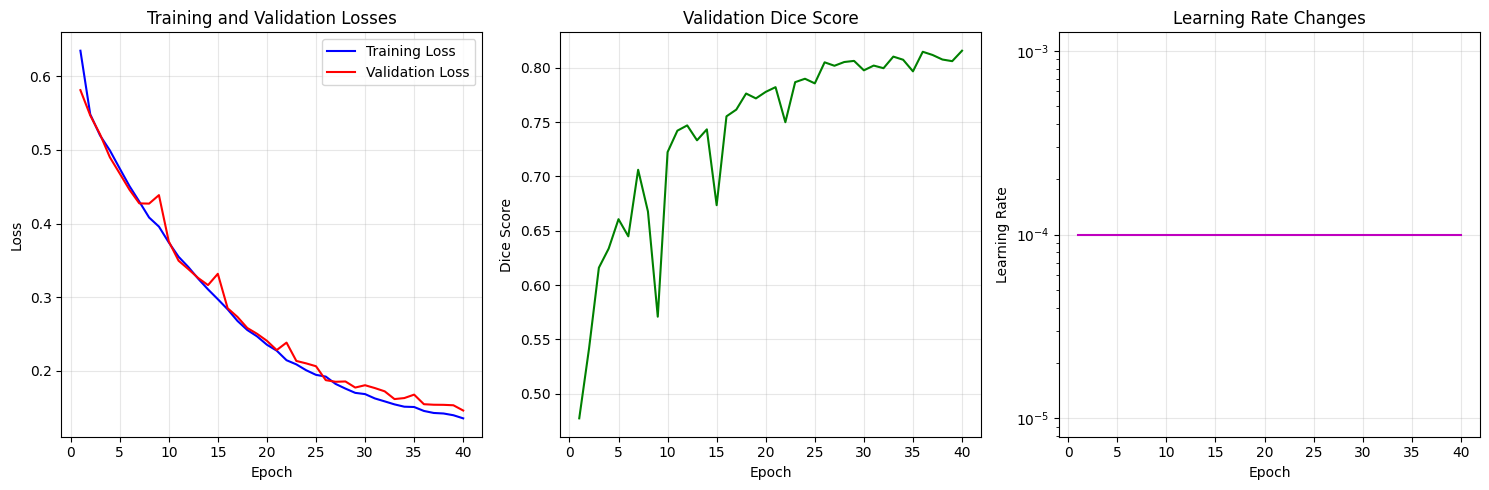

Epoch 41/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 41/50 - 64.4s
  Training Loss: 0.1387
  Validation Loss: 0.1521
  Dice Score: 0.8067
  Learning Rate: 0.000100


Epoch 42/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 42/50 - 63.9s
  Training Loss: 0.1368
  Validation Loss: 0.1543
  Dice Score: 0.8028
  Learning Rate: 0.000100


Epoch 43/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 43/50 - 64.0s
  Training Loss: 0.1344
  Validation Loss: 0.1449
  Dice Score: 0.8122
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1449)


Epoch 44/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 44/50 - 64.1s
  Training Loss: 0.1342
  Validation Loss: 0.1369
  Dice Score: 0.8236
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1369)


Epoch 45/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 45/50 - 64.1s
  Training Loss: 0.1360
  Validation Loss: 0.1422
  Dice Score: 0.8131
  Learning Rate: 0.000100
  📁 Checkpoint saved: epoch_45


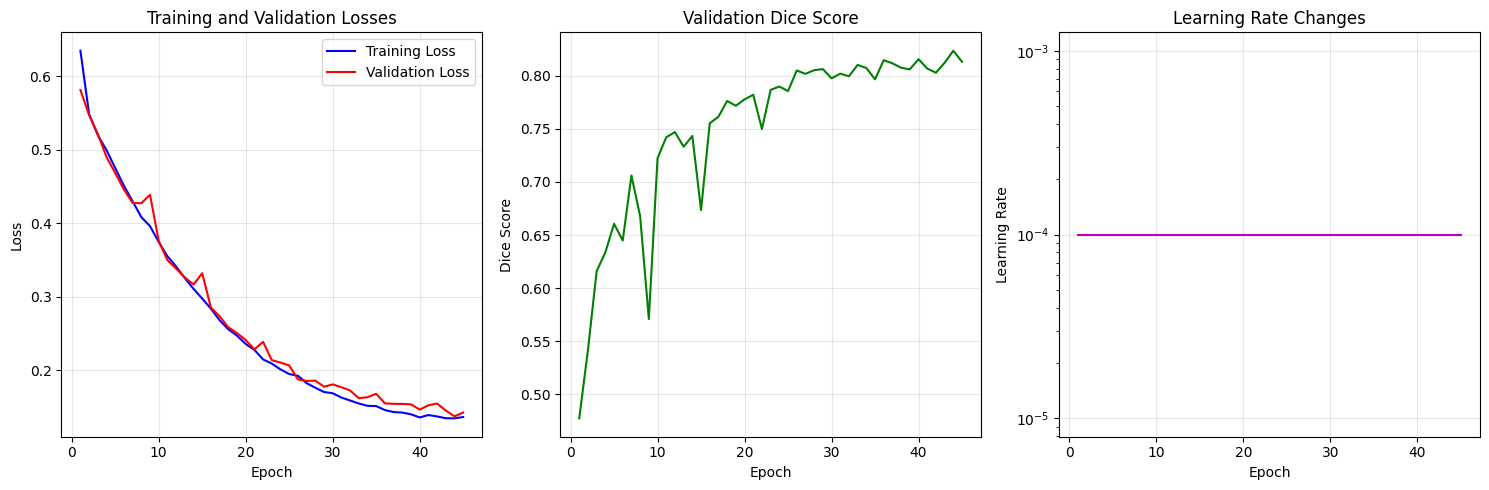

Epoch 46/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 46/50 - 64.2s
  Training Loss: 0.1272
  Validation Loss: 0.1401
  Dice Score: 0.8173
  Learning Rate: 0.000100


Epoch 47/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 47/50 - 63.8s
  Training Loss: 0.1250
  Validation Loss: 0.1377
  Dice Score: 0.8198
  Learning Rate: 0.000100


Epoch 48/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 48/50 - 64.1s
  Training Loss: 0.1245
  Validation Loss: 0.1388
  Dice Score: 0.8179
  Learning Rate: 0.000100


Epoch 49/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 49/50 - 64.1s
  Training Loss: 0.1240
  Validation Loss: 0.1327
  Dice Score: 0.8257
  Learning Rate: 0.000100
  ✅ New best model saved! (Val Loss: 0.1327)


Epoch 50/50 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 50/50 - 64.1s
  Training Loss: 0.1223
  Validation Loss: 0.1403
  Dice Score: 0.8128
  Learning Rate: 0.000100
  📁 Checkpoint saved: epoch_50


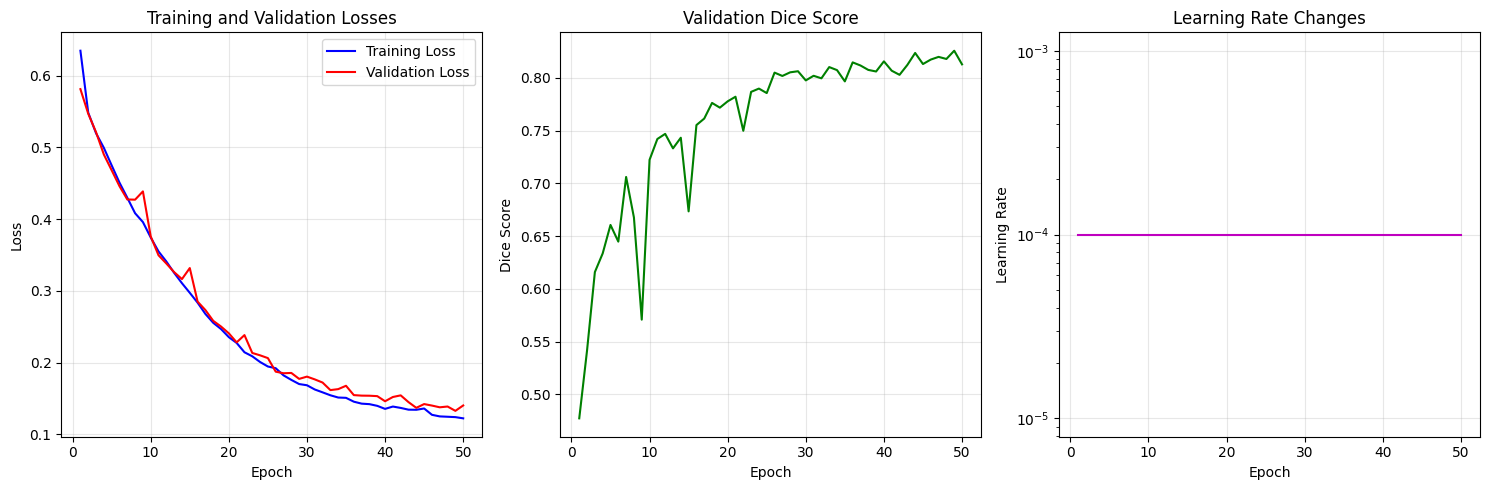


=============== TRAINING COMPLETED ===============
Total training time: 0h 56m 7s
Best validation loss: 0.1327
Final Dice score: 0.8128
Model saved: /content/drive/My Drive/Bitirme Projesi/SpineCheck-AI/models/unet_model_best_colab_harun.pth


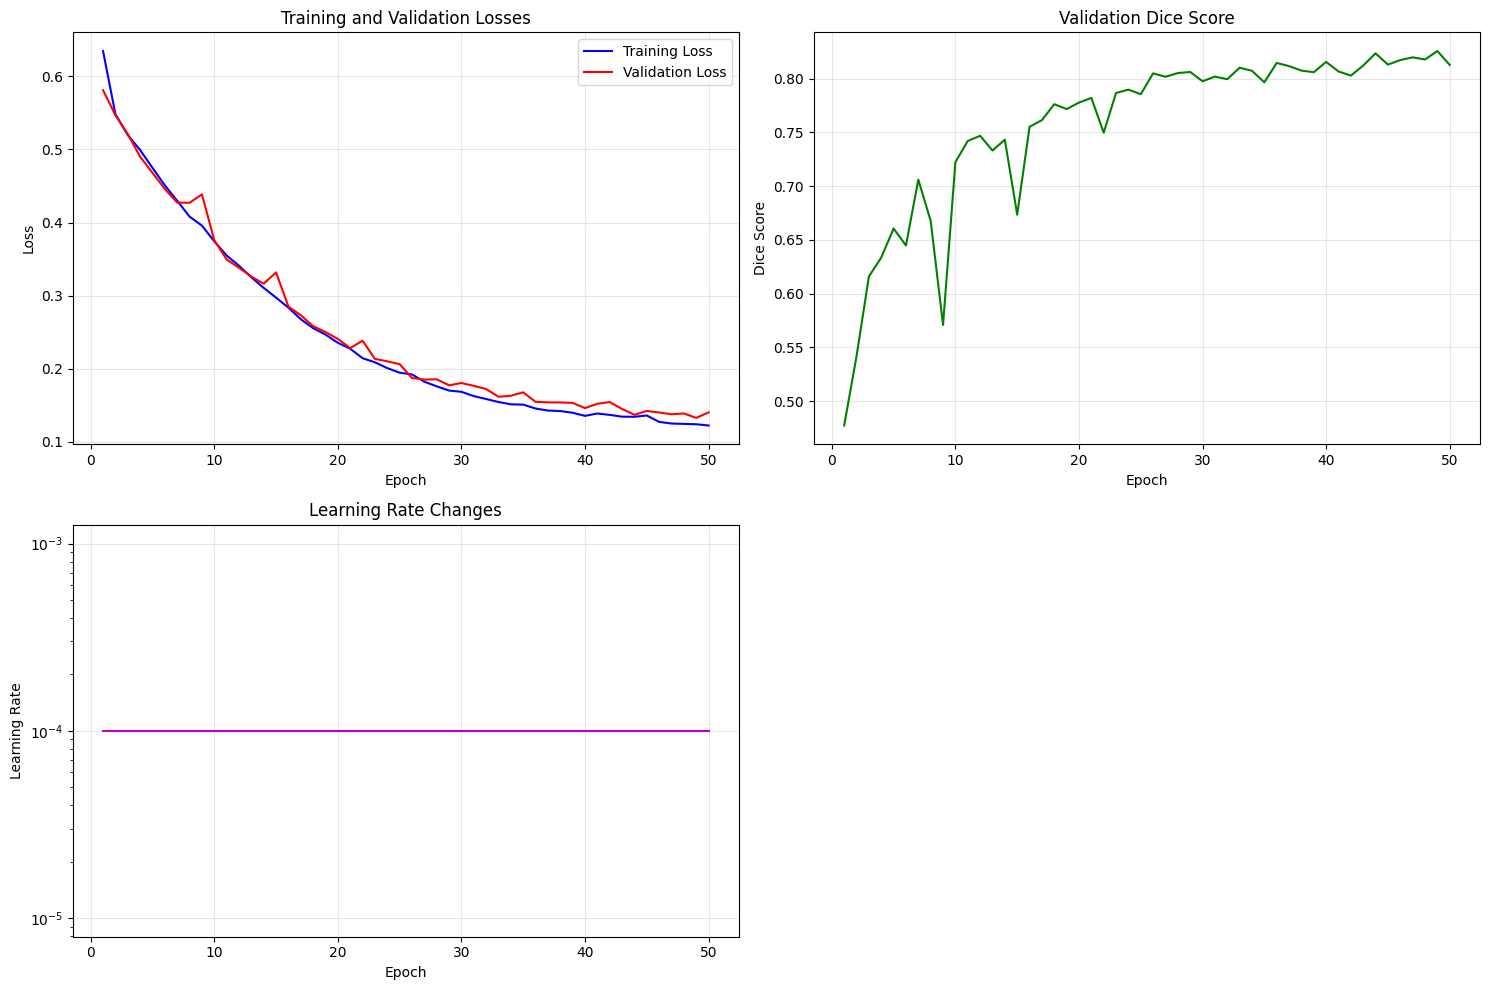

In [9]:
# Create the model
model = UNet(n_channels=3, n_classes=1, bilinear=True)
model = model.to(device)
print("Model created and moved to GPU.")

# View model architecture
print(f"\nModel Architecture:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params:,}")
print(f"Number of trainable parameters: {trainable_params:,}")

# Start training - training will begin when you run this cell
training_results = advanced_training_monitoring(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,  # You can adjust the number of epochs here
    lr=1e-4,    # Learning rate
    save_dir=os.path.join(project_directory, "models"),  # Save path
    checkpoint_freq=5  # How often to save checkpoints (in epochs)
)

**Eğitim Sonrası Model Değerlendirme ve Test**

Test veri yükleyicisi oluşturuluyor...

===== MODEL DEĞERLENDİRME =====
En iyi model yüklendi: /content/drive/My Drive/Bitirme Projesi/SpineCheck-AI/models/unet_model_best_colab.pth
Precision-Recall eğrisi oluşturuluyor...


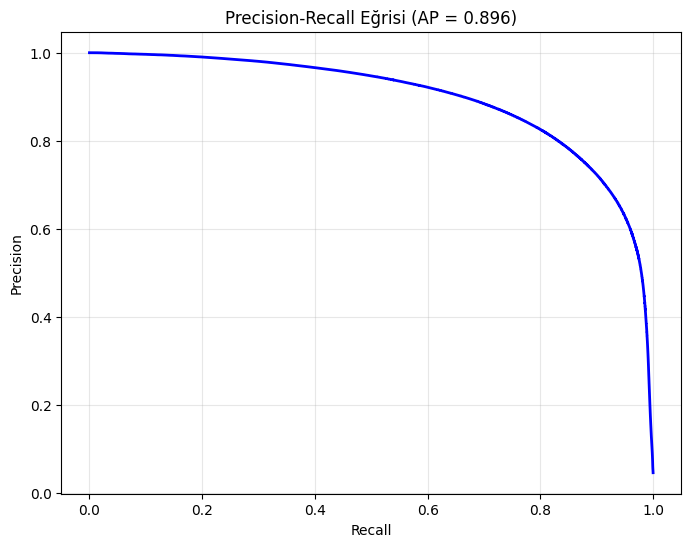

Segmentasyon örnekleri görselleştiriliyor...


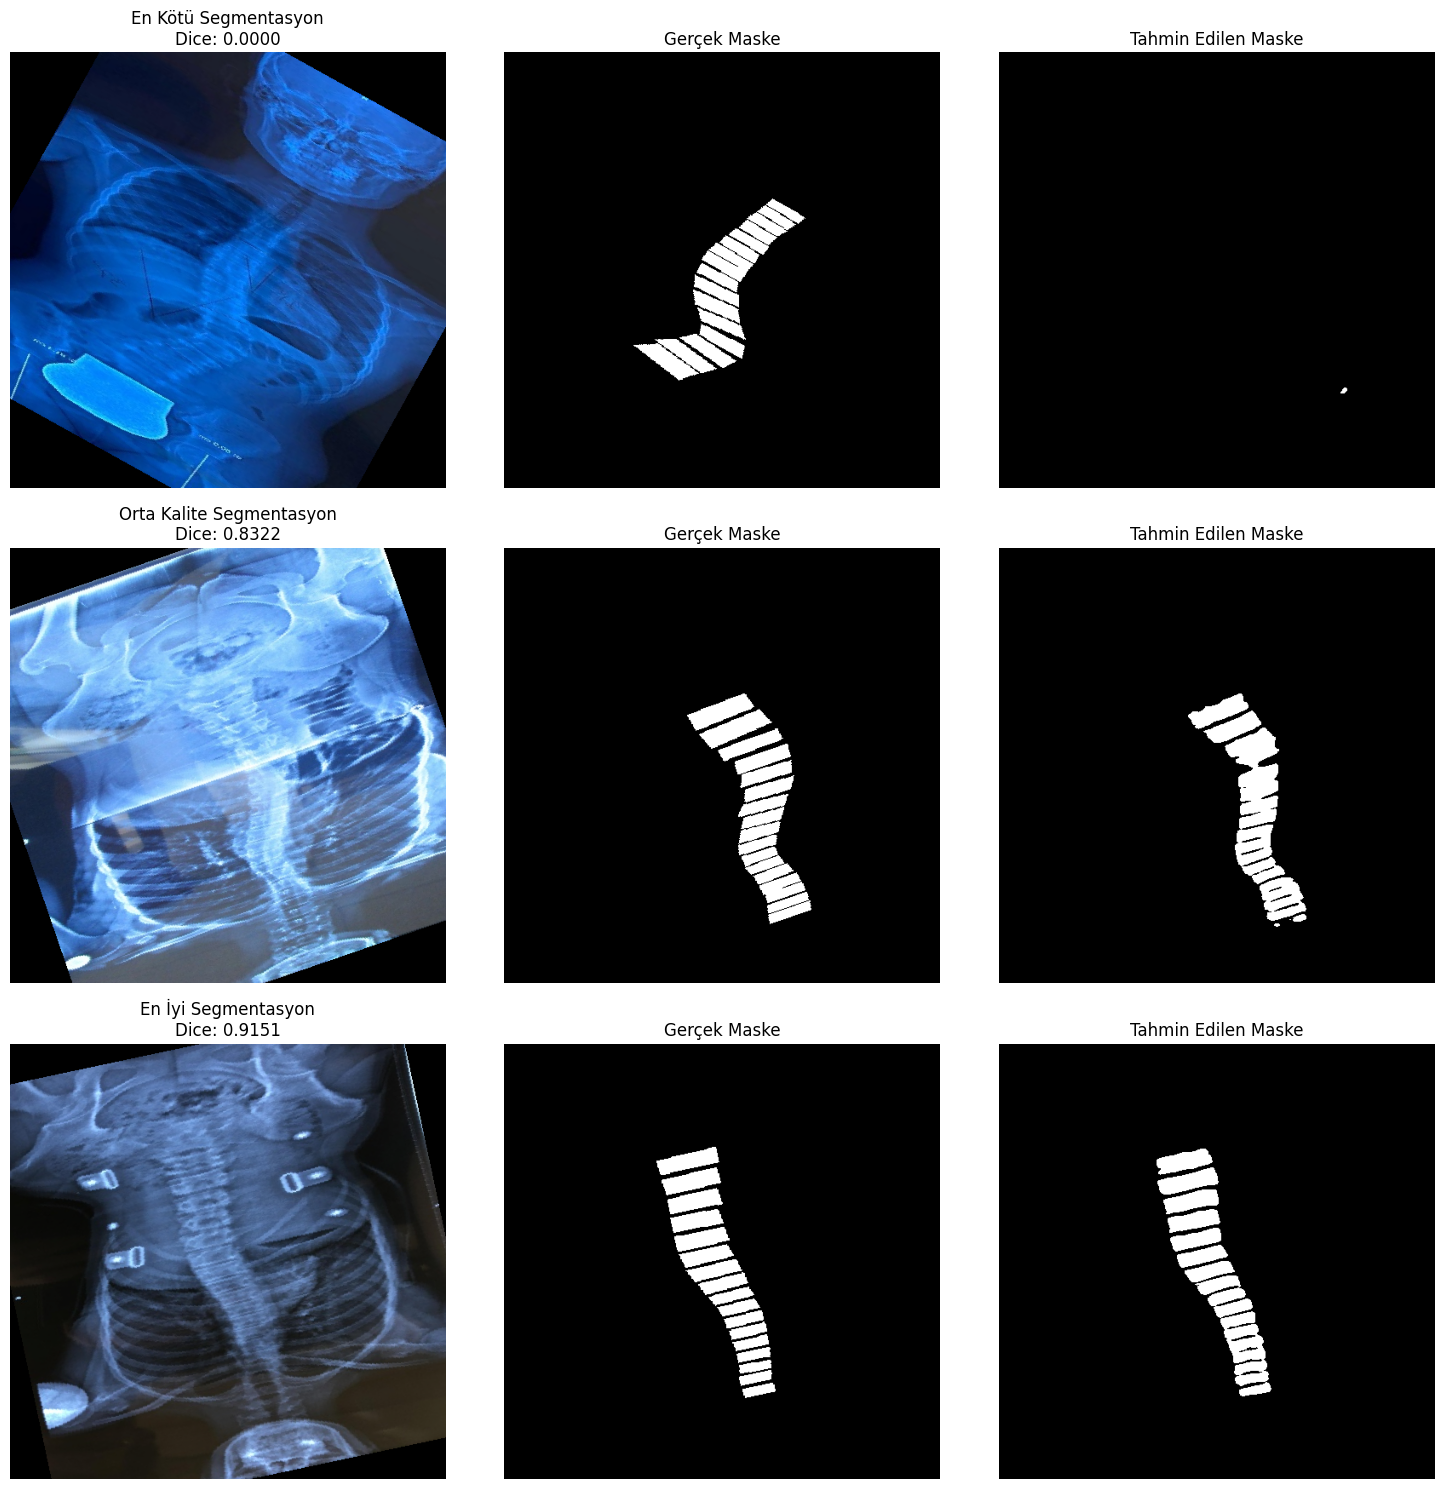

Dice skor dağılımı görselleştiriliyor...


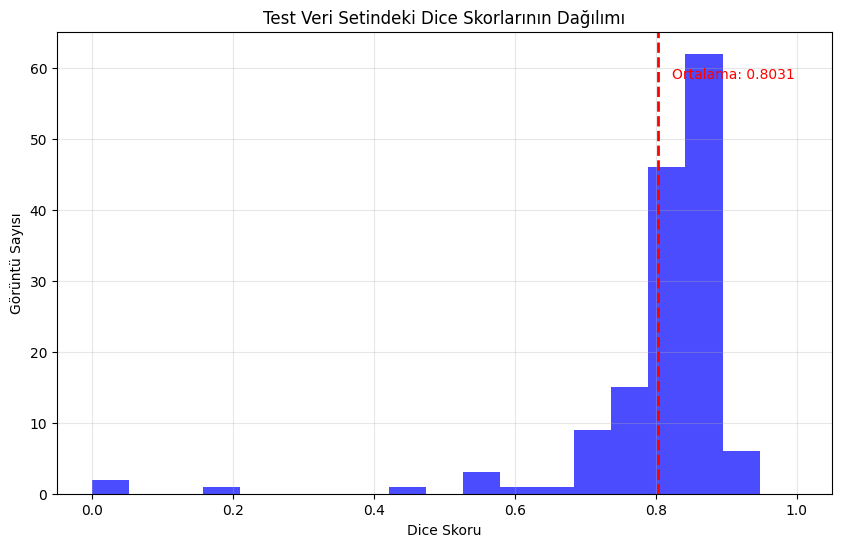

Eşik değeri analizi yapılıyor...


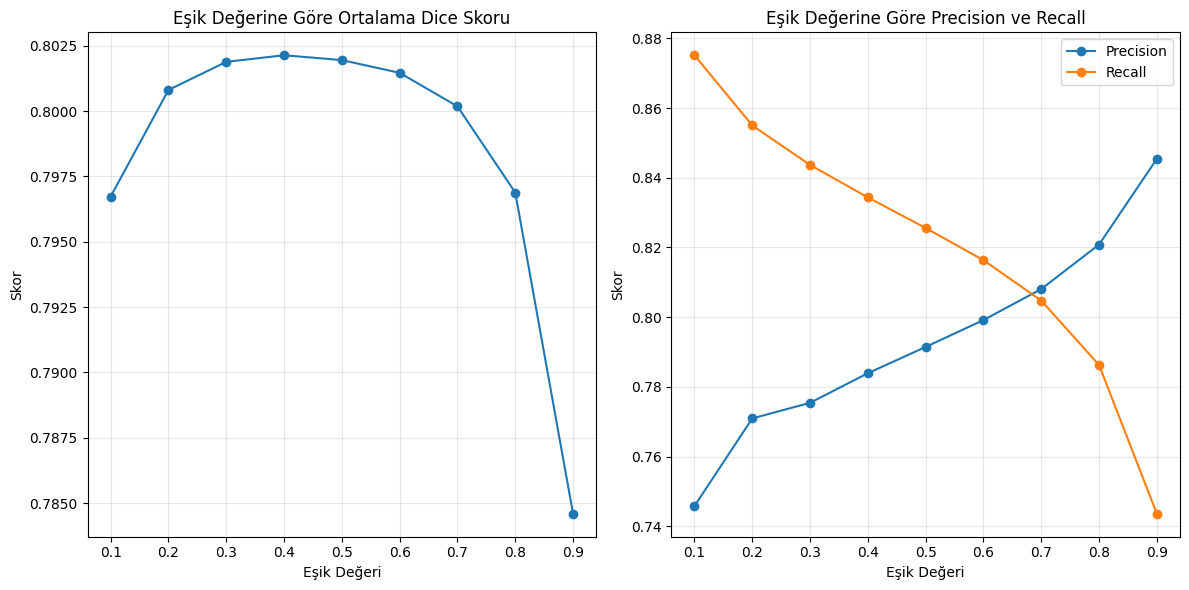

Piksel seviyesi karışıklık matrisi oluşturuluyor...


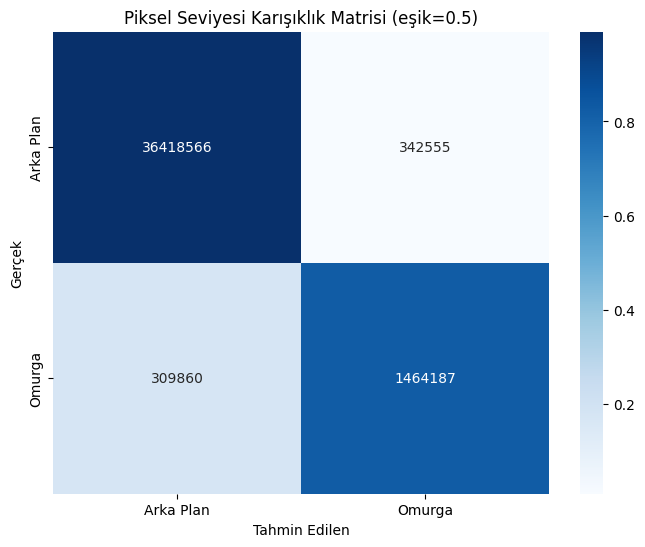

Model işlem süresi analizi yapılıyor...


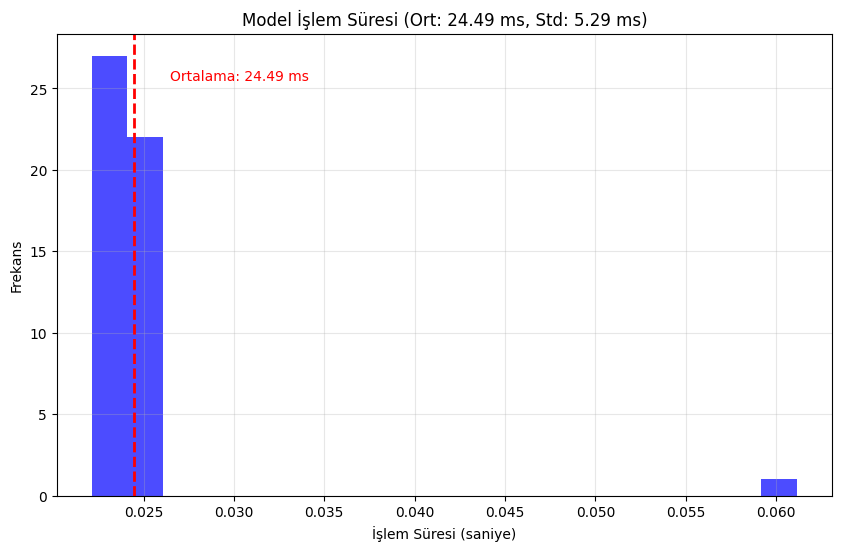

Ortalama işlem süresi: 24.49 ms
Standart sapma: 5.29 ms
FPS: 40.83
Saliency haritaları oluşturuluyor...


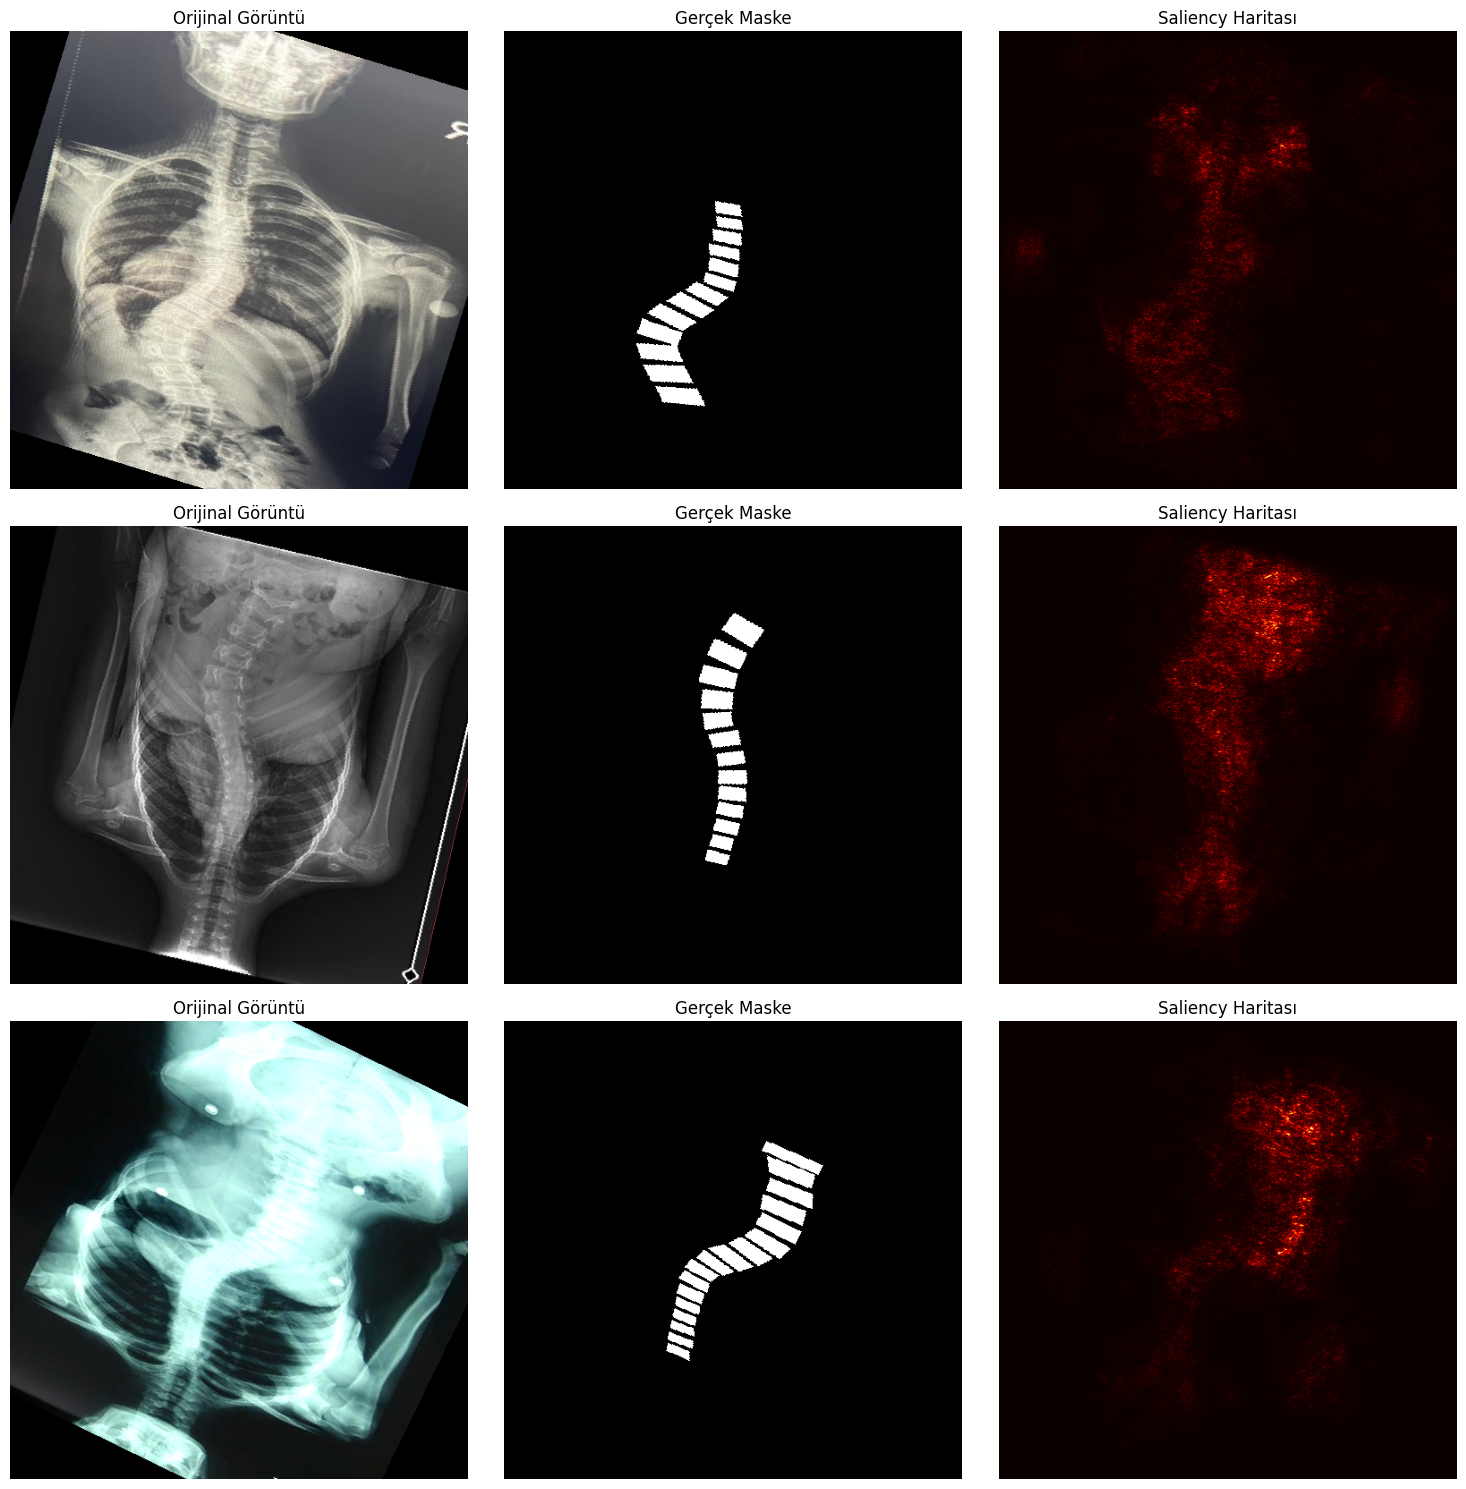


===== DEĞERLENDİRME TAMAMLANDI =====
Ortalama Dice Skoru: 0.8031
Average Precision Score: 0.8959
Ortalama İşlem Süresi: 24.49 ms


In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Test veri setinizi oluşturun (eğer henüz yoksa validation veri setini kullanabilirsiniz)
def create_test_loader(batch_size=8):
    # Validation veri setini test olarak kullanıyoruz (veya ayrı bir test veri setiniz varsa onu kullanabilirsiniz)
    print("Test veri yükleyicisi oluşturuluyor...")
    return val_loader  # Alternatif: Ayrı bir test veri setiniz varsa onu kullanabilirsiniz

test_loader = create_test_loader()

# 1. Precision-Recall Eğrisi
def generate_precision_recall_curve(model, test_loader, device):
    print("Precision-Recall eğrisi oluşturuluyor...")
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()

            all_preds.extend(probs.flatten())
            all_masks.extend(masks.cpu().numpy().flatten())

    precision, recall, thresholds = precision_recall_curve(all_masks, all_preds)
    ap = average_precision_score(all_masks, all_preds)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Eğrisi (AP = {ap:.3f})')
    plt.grid(True, alpha=0.3)
    plt.show()

    return precision, recall, thresholds, ap

# 2. Segmentasyon Kalitesi Görselleştirme
def visualize_segmentation_examples(model, test_loader, device, num_examples=3):
    print("Segmentasyon örnekleri görselleştiriliyor...")
    model.eval()
    results = []

    with torch.no_grad():
        for images, masks in test_loader:
            batch_size = images.shape[0]
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()

            # Her görüntü için Dice skoru hesaplama
            for i in range(batch_size):
                intersection = (pred_masks[i] * masks[i]).sum().item()
                dice = (2. * intersection) / (pred_masks[i].sum().item() + masks[i].sum().item() + 1e-8)

                results.append({
                    'image': images[i].cpu(),
                    'true_mask': masks[i].cpu(),
                    'pred_mask': pred_masks[i].cpu(),
                    'dice_score': dice
                })

            if len(results) >= 30:  # Yeterli örnek toplandı
                break

    # Dice skoruna göre sırala
    results.sort(key=lambda x: x['dice_score'])

    # En kötü, ortalama ve en iyi örnekleri seç
    examples = [
        ('En Kötü Segmentasyon', results[0]),
        ('Orta Kalite Segmentasyon', results[len(results)//2]),
        ('En İyi Segmentasyon', results[-1])
    ]

    # Görselleştir
    plt.figure(figsize=(15, 5*num_examples))
    for i, (title, result) in enumerate(examples):
        # Orijinal görüntü
        plt.subplot(num_examples, 3, i*3+1)
        img = result['image'].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Normalize et
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"{title}\nDice: {result['dice_score']:.4f}")
        plt.axis('off')

        # Gerçek maske
        plt.subplot(num_examples, 3, i*3+2)
        plt.imshow(result['true_mask'].squeeze(), cmap='gray')
        plt.title("Gerçek Maske")
        plt.axis('off')

        # Tahmin edilen maske
        plt.subplot(num_examples, 3, i*3+3)
        plt.imshow(result['pred_mask'].squeeze(), cmap='gray')
        plt.title("Tahmin Edilen Maske")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Dice Skor Dağılımı
def visualize_dice_distribution(model, test_loader, device):
    print("Dice skor dağılımı görselleştiriliyor...")
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()

            # Her görüntü için Dice skorunu hesapla
            for i in range(images.shape[0]):
                intersection = (pred_masks[i] * masks[i]).sum().item()
                dice = (2. * intersection) / (pred_masks[i].sum().item() + masks[i].sum().item() + 1e-8)
                dice_scores.append(dice)

    plt.figure(figsize=(10, 6))
    bins = np.linspace(0, 1, 20)
    plt.hist(dice_scores, bins=bins, alpha=0.7, color='blue')
    plt.axvline(np.mean(dice_scores), color='red', linestyle='dashed', linewidth=2)
    plt.text(np.mean(dice_scores)+0.02, plt.ylim()[1]*0.9, f'Ortalama: {np.mean(dice_scores):.4f}', color='red')
    plt.xlabel('Dice Skoru')
    plt.ylabel('Görüntü Sayısı')
    plt.title('Test Veri Setindeki Dice Skorlarının Dağılımı')
    plt.grid(True, alpha=0.3)
    plt.show()

    return dice_scores

# 4. Eşik Değeri Analizi
def threshold_analysis(model, test_loader, device):
    print("Eşik değeri analizi yapılıyor...")
    model.eval()
    thresholds = np.arange(0.1, 1.0, 0.1)
    threshold_metrics = {t: {'dice': [], 'precision': [], 'recall': []} for t in thresholds}

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)

            for threshold in thresholds:
                pred_masks = (probs > threshold).float()

                # Batch için metrikleri hesapla
                for i in range(images.shape[0]):
                    true_pos = (pred_masks[i] * masks[i]).sum().item()
                    false_pos = (pred_masks[i] * (1 - masks[i])).sum().item()
                    false_neg = ((1 - pred_masks[i]) * masks[i]).sum().item()

                    dice = (2. * true_pos) / (2 * true_pos + false_pos + false_neg + 1e-8)
                    precision = true_pos / (true_pos + false_pos + 1e-8)
                    recall = true_pos / (true_pos + false_neg + 1e-8)

                    threshold_metrics[threshold]['dice'].append(dice)
                    threshold_metrics[threshold]['precision'].append(precision)
                    threshold_metrics[threshold]['recall'].append(recall)

    # Ortalamaları hesapla
    avg_metrics = {t: {m: np.mean(vals) for m, vals in metrics.items()}
                   for t, metrics in threshold_metrics.items()}

    # Grafiği çiz
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(thresholds, [avg_metrics[t]['dice'] for t in thresholds], 'o-', label='Dice')
    plt.xlabel('Eşik Değeri')
    plt.ylabel('Skor')
    plt.title('Eşik Değerine Göre Ortalama Dice Skoru')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(thresholds, [avg_metrics[t]['precision'] for t in thresholds], 'o-', label='Precision')
    plt.plot(thresholds, [avg_metrics[t]['recall'] for t in thresholds], 'o-', label='Recall')
    plt.xlabel('Eşik Değeri')
    plt.ylabel('Skor')
    plt.title('Eşik Değerine Göre Precision ve Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return avg_metrics

# 5. Piksel Seviyesi Karışıklık Matrisi
def plot_pixel_confusion_matrix(model, test_loader, device, threshold=0.5):
    print("Piksel seviyesi karışıklık matrisi oluşturuluyor...")
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred_masks = (torch.sigmoid(outputs) > threshold).float()

            all_preds.extend(pred_masks.flatten().cpu().numpy())
            all_masks.extend(masks.flatten().cpu().numpy())

    # Karışıklık matrisini oluştur
    cm = confusion_matrix(all_masks, all_preds)

    # Normalize et
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Grafiği çiz
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap="Blues",
                xticklabels=['Arka Plan', 'Omurga'],
                yticklabels=['Arka Plan', 'Omurga'])
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title(f'Piksel Seviyesi Karışıklık Matrisi (eşik={threshold})')
    plt.show()

    return cm

# 6. Model İşlem Süresi Analizi
def analyze_inference_time(model, test_loader, device, num_runs=50):
    print("Model işlem süresi analizi yapılıyor...")
    model.eval()
    image_sizes = []
    inference_times = []

    # Isınma turu
    for _ in range(10):
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                _ = model(images)
                break

    # İşlem süresini ölç
    for images, _ in test_loader:
        batch_size = images.shape[0]

        for i in range(min(batch_size, num_runs // len(test_loader) + 1)):
            img = images[i:i+1].to(device)
            image_sizes.append(img.shape)

            # Zamanı ölç
            torch.cuda.synchronize()
            start_time = time.time()

            with torch.no_grad():
                _ = model(img)

            torch.cuda.synchronize()
            end_time = time.time()

            inference_times.append(end_time - start_time)

            if len(inference_times) >= num_runs:
                break

        if len(inference_times) >= num_runs:
            break

    avg_time = np.mean(inference_times)
    std_time = np.std(inference_times)

    plt.figure(figsize=(10, 6))
    plt.hist(inference_times, bins=20, alpha=0.7, color='blue')
    plt.axvline(avg_time, color='red', linestyle='dashed', linewidth=2)
    plt.text(avg_time+0.002, plt.ylim()[1]*0.9, f'Ortalama: {avg_time*1000:.2f} ms', color='red')
    plt.xlabel('İşlem Süresi (saniye)')
    plt.ylabel('Frekans')
    plt.title(f'Model İşlem Süresi (Ort: {avg_time*1000:.2f} ms, Std: {std_time*1000:.2f} ms)')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Ortalama işlem süresi: {avg_time*1000:.2f} ms")
    print(f"Standart sapma: {std_time*1000:.2f} ms")
    print(f"FPS: {1/avg_time:.2f}")

    return inference_times

# 7. Saliency Map / Dikkat Görselleştirme
def generate_saliency_maps(model, test_loader, device, num_examples=3):
    print("Saliency haritaları oluşturuluyor...")
    model.eval()

    # Görüntü batch'i al
    for images, masks in test_loader:
        break

    images = images[:num_examples].to(device)
    masks = masks[:num_examples].to(device)

    # Görüntü tensorlarını kopyala ve gradyan hesaplamasını etkinleştir
    images.requires_grad_()

    # İleri geçiş
    outputs = model(images)

    # Girdiye göre gradyanı hesapla
    loss = outputs.sum()
    loss.backward()

    # Gradyanları al
    gradients = images.grad.abs()

    # Görselleştirme için gradyanları normalize et
    saliency_maps = gradients.sum(dim=1)
    saliency_maps = saliency_maps / saliency_maps.view(num_examples, -1).max(1)[0].view(num_examples, 1, 1)

    # Görselleştir
    plt.figure(figsize=(15, 5*num_examples))
    for i in range(num_examples):
        # Orijinal görüntü
        plt.subplot(num_examples, 3, i*3+1)
        img = images[i].detach().cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Normalize et
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title("Orijinal Görüntü")
        plt.axis('off')

        # Gerçek maske
        plt.subplot(num_examples, 3, i*3+2)
        plt.imshow(masks[i].cpu().squeeze().detach().numpy(), cmap='gray')
        plt.title("Gerçek Maske")
        plt.axis('off')

        # Saliency haritası
        plt.subplot(num_examples, 3, i*3+3)
        plt.imshow(saliency_maps[i].cpu().detach().numpy(), cmap='hot')
        plt.title("Saliency Haritası")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Değerlendirme fonksiyonlarını çağır
print("\n===== MODEL DEĞERLENDİRME =====")
print("En iyi model yüklendi:", best_model_path)

# Tüm değerlendirme grafikleri için fonksiyonları çağır
precision, recall, thresholds, ap = generate_precision_recall_curve(model, test_loader, device)

visualize_segmentation_examples(model, test_loader, device)

dice_scores = visualize_dice_distribution(model, test_loader, device)

threshold_metrics = threshold_analysis(model, test_loader, device)

cm = plot_pixel_confusion_matrix(model, test_loader, device)

inference_times = analyze_inference_time(model, test_loader, device)

generate_saliency_maps(model, test_loader, device)

print("\n===== DEĞERLENDİRME TAMAMLANDI =====")
print(f"Ortalama Dice Skoru: {np.mean(dice_scores):.4f}")
print(f"Average Precision Score: {ap:.4f}")
print(f"Ortalama İşlem Süresi: {np.mean(inference_times)*1000:.2f} ms")